# 2. Logistic regression for classfication problem
## 2.1 Implementation using sklearn

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression

from tqdm.notebook import tqdm
import time

#### Data and problem description.
Dataset describes vehicle CO2 emission and includes different vehicle parameters; in this case we are going to predict type of fuel with CO2 emission and fuel consumption. 
* *CO2 Emissions(g/km)* - integer value
* *Fuel Consumption Comb (L/100 km)* - float value
* *Fuel Type* - categorical value, {Gasoline, Diesel, Ethanol}

So, model should get $n\times2$ vector and return $n\times3$ vector.

In [180]:
# load data
df = pd.read_csv("CO2_Emissions_Canada.csv").sample(frac=1)

# drop unused parameters, change data view
fuel_type = {0:'Gasoline', 1:'Diesel', 2:'Ethanol'}
fuel_to_num = {'X': 0, 'Z':0, 'D':1, 'E':2}
df_c = df.loc[df['Fuel Type'] != 'N', ["Fuel Consumption Comb (L/100 km)", "CO2 Emissions(g/km)", 'Fuel Type']]
df_c['Fuel Type'] = df_c['Fuel Type'].map(lambda x: fuel_to_num[x])

# separate data by fuel type
df_gasoline = df_c.loc[df_c["Fuel Type"] == 0, :].reset_index(drop=True)
df_diesel = df_c.loc[df_c["Fuel Type"] == 1, :].reset_index(drop=True)
df_ethanol = df_c.loc[df_c["Fuel Type"] ==2 , :].reset_index(drop=True)

print('-Samples count-', 'Gasoline: {}'.format(len(df_gasoline)),'Diesel: {}'.format(len(df_diesel)),'Ethanol: {}'.format(len(df_ethanol)), sep='\n')

df_c.head()

-Samples count-
Gasoline: 6839
Diesel: 175
Ethanol: 370


,Fuel Consumption Comb (L/100 km),CO2 Emissions(g/km),Fuel Type
1004,11.9,274,0
3299,10.1,233,0
4172,9.8,230,0
5119,12.4,291,0
5682,18.4,305,2


Define function for splitting dat into training, validation, testing datasets:


In [181]:
def split_dataset(df_list, train_count):
   
    # split data into dataframes
    df_train_list, df_valid_list, df_test_list = [], [], []
    for df in df_list:
        n = len(df)
        df = df.sample(frac=1).reset_index(drop=True)
        df_train_list.append(df.loc[0:train_count, :])
        df_test_list.append(df.loc[train_count:, :])
  
    df_tr, df_test =  pd.concat(df_train_list,ignore_index=True), pd.concat(df_test_list,ignore_index=True)

    # convert to tensors
    ttrain = [np.transpose(np.array([df_tr.iloc[:,0], df_tr.iloc[:,1]])), np.array(df_tr.iloc[:,2])]
    ttest = [np.transpose(np.array(([df_test.iloc[:,0], df_test.iloc[:,1]]))),np.array(df_test.iloc[:,2])]
    # create df for plotting
    df_test['Fuel Type'] = df_test['Fuel Type'].map(lambda x: fuel_type[x])
    df_tr['Fuel Type'] = df_tr['Fuel Type'].map(lambda x: fuel_type[x])
    return ttrain, ttest, df_tr, df_test

In [247]:
# get train and test datasets (using 20 samples for train)
train_data, test_data, df_plot, df_test = split_dataset([df_gasoline, df_diesel, df_ethanol], 20)


Plotting training data:

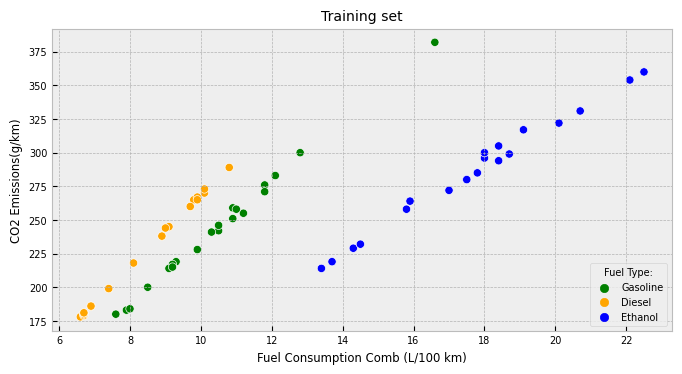

In [256]:
fig = plt.figure(figsize=(8, 4), dpi=100)
plt.style.use('bmh')
plt.rcParams.update({'font.size': 7})

ax = fig.add_subplot(111)
palette ={"Gasoline": "green", "Diesel": "orange", "Ethanol": "blue"}
sns.scatterplot(data=df_plot, x="Fuel Consumption Comb (L/100 km)", y="CO2 Emissions(g/km)", hue = "Fuel Type", palette=palette)

plt.title('Training set')
plt.ylabel('CO2 Emissions(g/km)')
plt.xlabel('Fuel Consumption Comb (L/100 km)')

plt.legend(frameon=True, title='Fuel Type:', loc="lower right")

plt.savefig("fuel_type_training_set.png")
plt.show()


Create and learn model:


In [257]:
classifier = LogisticRegression(random_state=0, max_iter=500).fit(train_data[0], train_data[1])
print('Accuracy:')
classifier.score(test_data[0], test_data[1])

Accuracy:


0.9976788640087384

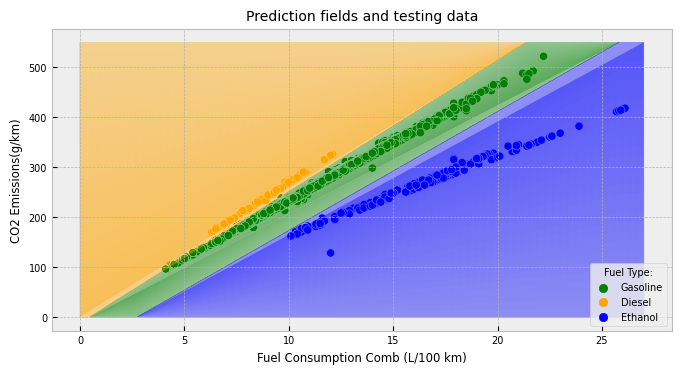

In [253]:
# plot fields

n = 500
x = np.linspace(0, 27., 2*n) 
y = np.linspace(0, 550, n).astype('int')
X, Y = np.meshgrid(x, y) 

space_input = np.transpose(np.array([X.flatten(order='F'), Y.flatten(order='F')]))
space_pred = classifier.predict(space_input)
df_data = pd.DataFrame({'X':X.flatten(order='F'), 'Y':Y.flatten(order='F'), 'Z':pd.Series(space_pred).map(lambda x: fuel_type[x])})


fig = plt.figure(figsize=(8, 4), dpi=100)
ax = fig.add_subplot(111)
plt.style.use('bmh')
plt.rcParams.update({'font.size': 7})

a = 0.4
plt.fill(df_data.loc[df_data['Z']=='Gasoline','X'], df_data.loc[df_data['Z']=='Gasoline','Y'], c='green', alpha=a, joinstyle='round')
plt.fill(df_data.loc[df_data['Z']=='Diesel','X'], df_data.loc[df_data['Z']=='Diesel','Y'], c='orange', alpha=a, joinstyle='round')
plt.fill(df_data.loc[df_data['Z']=='Ethanol','X'], df_data.loc[df_data['Z']=='Ethanol','Y'], c='blue', alpha=a, joinstyle='round')

sns.scatterplot(data=df_test, x="Fuel Consumption Comb (L/100 km)", y="CO2 Emissions(g/km)", hue = "Fuel Type", palette=palette)

plt.title('Prediction fields and testing data')
plt.ylabel('CO2 Emissions(g/km)')
plt.xlabel('Fuel Consumption Comb (L/100 km)')

plt.legend(frameon=True, title='Fuel Type:', loc="lower right")

plt.savefig("fields-and-testing-data.png")
plt.show()